In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data.dataset import random_split

coord = 10

#this is the code for loading all the data and storing it together, just rotating one particle to x-axis
learning_num = 6
qho_samples = np.ndarray([(learning_num-2)*1000000,coord], dtype = 'complex64')
lll_samples = np.ndarray([(learning_num-2)*1000000,coord], dtype = 'complex64')
                          
for i in range(3,learning_num+1):
    samples = np.load(f"{i}_QHO_1mil_samples.npy")
    com_samples = np.sum(samples,axis = 1)/i
    samples = samples - com_samples[:,np.newaxis]
    trans_samples = np.abs(samples)*np.exp(1j*(np.angle(samples)-np.angle(samples[:,0][:,np.newaxis])))
    qho_samples[int((i-3)*1000000):int((i-3+1)*1000000),:np.shape(samples)[1]] = trans_samples
                              
for i in range(3,learning_num+1):
    samples = np.load(f"{i}_LLL_1mil_samples.npy")
    com_samples = np.sum(samples,axis = 1)/i
    samples = samples - com_samples[:,np.newaxis]
    trans_samples = np.abs(samples)*np.exp(1j*(np.angle(samples)-np.angle(samples[:,0][:,np.newaxis])))
    lll_samples[int((i-3)*1000000):int((i-3+1)*1000000),:np.shape(samples)[1]] = trans_samples
    
combined_samples = np.concatenate([qho_samples, lll_samples], axis=0)

qho_labels = np.zeros((qho_samples.shape[0], 1), dtype=int)  # 0s for qho_samples
lll_labels = np.ones((lll_samples.shape[0], 1), dtype=int)   # 1s for lll_samples
#tensor of class labels
combined_labels = torch.tensor(np.concatenate([qho_labels, lll_labels], axis=0), dtype = torch.long).squeeze(1)
#labels_tensor = torch.zeros([combined_labels.shape[0],2])
#labels_tensor[:,0] = 1
#labels_tensor[combined_labels.bool(),:] = torch.tensor([0,1],dtype = torch.float)

combined_samples_xy = np.ndarray([np.shape(combined_samples)[0],np.shape(combined_samples)[1],2],dtype = 'float32')
combined_samples_xy[:,:,0] = np.real(combined_samples)
combined_samples_xy[:,:,1] = np.imag(combined_samples)

#formating for conv1d with kernal_size=2, stride = 2:
combined_samples_xy_flat = combined_samples_xy.reshape(np.shape(combined_samples_xy)[0],2*np.shape(combined_samples_xy)[1])

samples_tensor_xy = torch.tensor(combined_samples_xy_flat)

#creating dataset of samples and their labels
samples_dataset = TensorDataset(samples_tensor_xy,combined_labels)

train_dataset, val_dataset = random_split(samples_dataset, [0.9, 0.1])

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

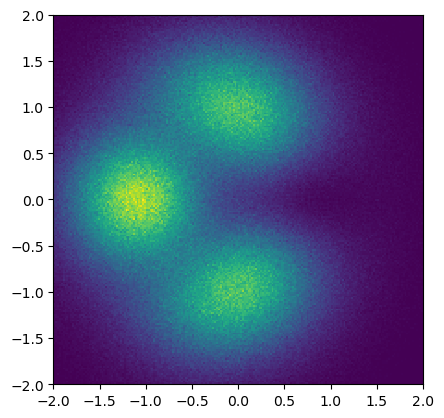

In [456]:
import matplotlib.pyplot as plt
import matplotlib as mpl

shifted_rad_rotx_first_2 = combined_samples_xy[1000000:2000000,1:4,:]
#shifted_rad_rotx_first_5=radial_samples_5_center_removed[:,1:,:]
fig = plt.figure()
ax = fig.add_subplot(111)
#c = ax.hist2d([coord[1] for sample in shifted_rad_rotx_first_2 for coord in sample],[coord[0] for sample in shifted_rad_rotx_first_2 for coord in sample],(200,200))
ax.hist2d(np.ndarray.flatten(shifted_rad_rotx_first_2[:,:,0]),np.ndarray.flatten(shifted_rad_rotx_first_2[:,:,1]),(200,200),norm=mpl.colors.PowerNorm(1),range = np.array([(-2,2),(-2,2)]))
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_aspect('equal', 'box')
#plt.hist2d(np.ndarray.flatten(shifted_rad_rotx_first_5[:,:,0]),np.ndarray.flatten(shifted_rad_rotx_first_5[:,:,1]),(200,200))
plt.show()

In [2]:
import torch
from torch import nn

def init_weights(mod):
    if (type(mod) == nn.Conv2d) or (type(mod) == nn.Linear):
        torch.nn.init.orthogonal_(mod.weight)

class WaveClassifier(nn.Module):
    def __init__(self, sequence_length, embedding_dim, hidden_size):
        super(WaveClassifier, self).__init__()
        
        # Note: since you have one channel, the input channel size for Conv1d is 1.
        #embedding_dim is the number of output channels, essentially we are projecting all of our smaples onto a subspace of this dim
        self.embedding_dim = embedding_dim
        #hidden_size is how many neurons there are to connect and build complex relationships with the embedding channels. 
        self.hidden_size = hidden_size

        # Convolutional layer
        self.conv = nn.Conv1d(1, self.embedding_dim, kernel_size=2, stride=2, padding=0)
        torch.nn.init.orthogonal_(self.conv.weight)
        # Hidden layers
        self.hidden = nn.Sequential(
            nn.Linear(self.embedding_dim * sequence_length, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU()
        )
        self.hidden.apply(init_weights)
        
        # Output layer
        self.out = nn.Linear(self.hidden_size, 2)  # Two output classes: LLL and QHO
        torch.nn.init.orthogonal_(self.out.weight)
        self.logsoft = nn.LogSoftmax(dim = 1)
    
    def forward(self, x):
        # Reshaping x to match the (batch_size, channels, sequence_length) format expected by nn.Conv1d
        # Since there's only one channel, we add an extra dimension for the channel.
        x = x.unsqueeze(1)
        
        x = self.conv(x)
        
        x = x.view(x.size(0), -1)  # Flatten the output of the convolutional layer
        x = self.hidden(x)
        x = self.out(x)
        out = self.logsoft(x) # Apply softmax to output the probabilities
        return out


In [9]:
model = WaveClassifier(10,50,64)

In [10]:
model(samples_tensor_xy[10000:10002])

In [59]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

loss_fn = nn.NLLLoss()

n_total_steps = len(train_loader)
num_epochs = 1
running_loss = 0.0
learning_rate = 0.01
coord = 10
embed_dim = 50
hidden_dim = 64
string_counter = 2

model_string = f"COMWaveClassifier3L_lr_{learning_rate}_coord_{coord}_ed_{embed_dim}_hd_{hidden_dim}_bs_{batch_size}"
#automatically changing the model_string if we are remaking a model with the same parameters
if os.path.exists('models/sgd/' + model_string):
    while os.path.exists('models/sgd/' + str(string_counter) + model_string):
        string_counter +=1
    model_string = str(string_counter) + model_string
model_string


writer = SummaryWriter('runs/sgd/' + model_string)
#writer = SummaryWriter(f"runs/test1")

model = WaveClassifier(coord,embed_dim,hidden_dim)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
    for i,(batch_samples, batch_labels) in enumerate(train_loader,0):
        model.train()
        pred = model(batch_samples)
        loss = loss_fn(pred, batch_labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 8000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            writer.add_scalar('training loss',running_loss, epoch*n_total_steps + i)
            running_loss = 0.0
            model.eval()
            total = 0
            correct = 0
            with torch.no_grad():
                for test_samples, test_labels in val_loader:
                    output = model(test_samples)
                    _, test_pred = torch.max(torch.exp(output.data), 1)
                    total += test_labels.size()[0]
                    correct += (test_pred == test_labels).sum().item()
            accuracy = correct/total
            print('accuracy: ', accuracy)
            writer.add_scalar('accuracy',accuracy, epoch*n_total_steps + i)
    running_loss = 0

writer.flush()
writer.close()
torch.save(model.state_dict(), 'models/sgd/' + model_string)


[1,  1000] loss: 0.653
accuracy:  0.63614875
[1,  2000] loss: 0.627
accuracy:  0.64264
[1,  3000] loss: 0.612
accuracy:  0.66116125
[1,  4000] loss: 0.597
accuracy:  0.67792875
[1,  5000] loss: 0.590
accuracy:  0.67982
[1,  6000] loss: 0.586
accuracy:  0.68022875
[1,  7000] loss: 0.582
accuracy:  0.68643375
[1,  8000] loss: 0.579
accuracy:  0.68683
[1,  9000] loss: 0.580
accuracy:  0.6812575
[1, 10000] loss: 0.575
accuracy:  0.69075
[1, 11000] loss: 0.574
accuracy:  0.694145
[1, 12000] loss: 0.572
accuracy:  0.687855
[1, 13000] loss: 0.569
accuracy:  0.6943025
[1, 14000] loss: 0.570
accuracy:  0.6966575
[1, 15000] loss: 0.565
accuracy:  0.697975
[1, 16000] loss: 0.567
accuracy:  0.7007
[1, 17000] loss: 0.566
accuracy:  0.69999375
[1, 18000] loss: 0.563
accuracy:  0.69492375
[1, 19000] loss: 0.563
accuracy:  0.6974275
[1, 20000] loss: 0.563
accuracy:  0.698805
[1, 21000] loss: 0.562
accuracy:  0.69927625
[1, 22000] loss: 0.562
accuracy:  0.700315
[1, 23000] loss: 0.562
accuracy:  0.6999

In [3]:
def accTest(model, batch_size: int, numP: int, wavefn = 'qho', batches = 1000):
    model.eval()
    if wavefn == 'qho':
        data = qho_samples[np.where((qho_samples[:,numP:] == np.zeros([10-numP])).all(axis=1))]
        correct_label = 0
    elif wavefn == 'lll':
        data = lll_samples[np.where((lll_samples[:,numP:] == np.zeros([10-numP])).all(axis=1))]
        correct_label = 1
    else:
        raise ValueError("Incorrect wavefunction given")
    
    data_xy = np.ndarray([np.shape(data)[0],np.shape(data)[1],2],dtype = 'float32')
    data_xy[:,:,0] = np.real(data)
    data_xy[:,:,1] = np.imag(data)
    data_xy_flat = data_xy.reshape(np.shape(data_xy)[0],2*np.shape(data_xy)[1])

    data_tensor = TensorDataset(torch.tensor(data_xy_flat))
    data_loader = DataLoader(data_tensor, batch_size=batch_size, shuffle=True)
    total_correct = 0
    total = 0
    with torch.no_grad():
        for step, batch_samples in enumerate(data_loader):
            if step > batches:
                break
            prob_totals = torch.sum(torch.exp(model(batch_samples[0])),dim=0)
            pred = torch.argmax(prob_totals)
            total += 1
            if pred == correct_label:
                total_correct +=1
    return total_correct/total
                
        

In [11]:
n_total_steps = len(train_loader)
num_epochs = 1
running_loss = 0.0
learning_rate = 0.01
coord = 10
embed_dim = 50
hidden_dim = 64

model = WaveClassifier(10,50,64)
#model.load_state_dict(torch.load(f"models/adam/COMWaveClassifier_lr_{learning_rate}_coord_{coord}_ed_{embed_dim}_hd_{hidden_dim}_bs_{batch_size}"))
#model.load_state_dict(torch.load(f"models/adam/COMWaveClassifier3L_lr_{learning_rate}_coord_{coord}_ed_{embed_dim}_hd_{hidden_dim}_bs_{batch_size}"))
model_string = f"COMWaveClassifier3L_lr_{learning_rate}_coord_{coord}_ed_{embed_dim}_hd_{hidden_dim}_bs_{batch_size}"
model_string = '3COMWaveClassifier3L_lr_0.01_coord_10_ed_50_hd_64_bs_100'
model.load_state_dict(torch.load('models/sgd/' + model_string))

<All keys matched successfully>

In [12]:
#model = WaveClassifier(10,50,64)
#model.load_state_dict(torch.load('models/sgd/' + model_string))
#model.load_state_dict(torch.load(f"models/adam/COMWaveClassifier_lr_{learning_rate}_coord_{coord}_ed_{embed_dim}_hd_{hidden_dim}_bs_{batch_size}"))
#model.load_state_dict(torch.load(f"models/adam/COMWaveClassifier3L_lr_{learning_rate}_coord_{coord}_ed_{embed_dim}_hd_{hidden_dim}_bs_{batch_size}"))
#model.load_state_dict(torch.load('models/sgd/COMWaveClassifier3L_lr_0.01_coord_10_ed_50_hd_64_bs_100'))
qho_acc = np.zeros([4,10])
lll_acc = np.zeros([4,10])

for numP in range(3,7):
    for i in range(10):
        qho_acc[numP-3,i] = accTest(model, 1 + 5*i, numP, wavefn = 'qho', batches = 5000)
    
for numP in range(3,7):
    for i in range(10):
        lll_acc[numP-3,i] = accTest(model, 1 + 5*i, numP, wavefn = 'lll', batches = 5000)


In [13]:
print(qho_acc)
print(lll_acc)

[[0.70205959 0.86222755 0.92821436 0.96520696 0.97580484 0.9870026
  0.9920016  0.99480104 0.99840032 0.99680064]
 [0.71545691 0.89142172 0.95540892 0.97440512 0.98760248 0.99360128
  0.99680064 0.99820036 0.99940012 0.99980004]
 [0.70685863 0.90041992 0.9610078  0.97520496 0.98920216 0.99560088
  0.99760048 0.99880024 0.99940012 1.        ]
 [0.71885623 0.91421716 0.96960608 0.98860228 0.99440112 0.99720056
  0.99820036 0.99940012 0.99960008 0.99980004]]
[[0.56968606 0.79784043 0.87462507 0.92021596 0.94341132 0.96460708
  0.97640472 0.9840032  0.98780244 0.9930014 ]
 [0.58288342 0.77484503 0.84823035 0.89782044 0.93041392 0.94661068
  0.96480704 0.97520496 0.97460508 0.9870026 ]
 [0.64047191 0.85902819 0.94121176 0.95940812 0.98280344 0.98780244
  0.99360128 0.99720056 0.9990002  0.9990002 ]
 [0.70385923 0.92781444 0.97460508 0.98980204 0.99620076 0.99880024
  0.99940012 1.         1.         1.        ]]


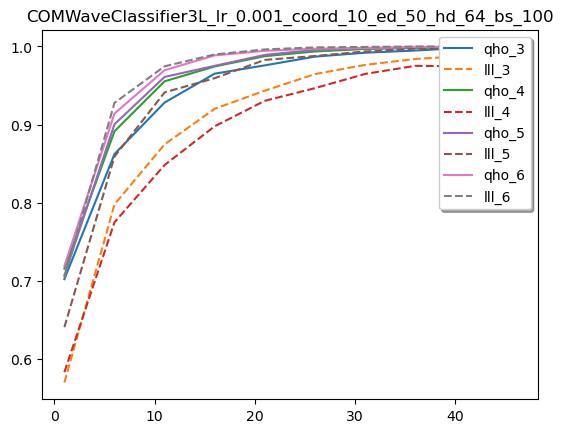

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for j in range(4):
    plt.plot([1 + 5*i for i in range(10)],qho_acc[j,:])
    plt.plot([1 + 5*i for i in range(10)],lll_acc[j,:], linestyle= 'dashed')
    
plt.title(model_string)
ax.legend(sum([[f"qho_{i}",f"lll_{i}"] for i in range(3,17)],[]), loc='upper right', shadow=True)

## Transfer learning

In [8]:
def transAccTest(model, batch_size: int, numP: int, wavefn = 'qho', batches = 1000):
    #currently numP doesn't do anything since we only have 7 particles as the untrained one.
    model.eval()
    if wavefn == 'qho':
        qho_7_samples = np.ndarray([1000000,10], dtype = 'complex64')
        samples = np.load(f"{numP}_QHO_1mil_samples.npy")
        com_samples = np.sum(samples,axis = 1)/numP
        samples = samples - com_samples[:,np.newaxis]
        trans_samples = np.abs(samples)*np.exp(1j*(np.angle(samples)-np.angle(samples[:,0][:,np.newaxis])))
        qho_7_samples[:,:np.shape(samples)[1]] = trans_samples
        data = qho_7_samples
        correct_label = 0
    elif wavefn == 'lll':
        lll_7_samples = np.ndarray([1000000,10], dtype = 'complex64')
        samples = np.load(f"{numP}_LLL_1mil_samples.npy")
        com_samples = np.sum(samples,axis = 1)/numP
        samples = samples - com_samples[:,np.newaxis]
        trans_samples = np.abs(samples)*np.exp(1j*(np.angle(samples)-np.angle(samples[:,0][:,np.newaxis])))
        lll_7_samples[:,:np.shape(samples)[1]] = trans_samples
        data = lll_7_samples
        correct_label = 1
    else:
        raise ValueError("Incorrect wavefunction given")
    
    data_xy = np.ndarray([np.shape(data)[0],np.shape(data)[1],2],dtype = 'float32')
    data_xy[:,:,0] = np.real(data)
    data_xy[:,:,1] = np.imag(data)
    data_xy_flat = data_xy.reshape(np.shape(data_xy)[0],2*np.shape(data_xy)[1])

    data_tensor = TensorDataset(torch.tensor(data_xy_flat))
    data_loader = DataLoader(data_tensor, batch_size=batch_size, shuffle=True)
    total_correct = 0
    total = 0
    with torch.no_grad():
        for step, batch_samples in enumerate(data_loader):
            if step > batches:
                break
            prob_totals = torch.sum(torch.exp(model(batch_samples[0])),dim=0)
            pred = torch.argmax(prob_totals)
            total += 1
            if pred == correct_label:
                total_correct +=1
    return total_correct/total
                
        

In [159]:
num_epochs = 1
running_loss = 0.0
learning_rate = 0.001
coord = 10
embed_dim = 50
hidden_dim = 64

model = WaveClassifier(10,50,64)
model.load_state_dict(torch.load(f"models/adam/COMWaveClassifier_lr_{learning_rate}_coord_{coord}_ed_{embed_dim}_hd_{hidden_dim}_bs_{batch_size}"))
#model.load_state_dict(torch.load(f"models/adam/COMWaveClassifier3L_lr_{learning_rate}_coord_{coord}_ed_{embed_dim}_hd_{hidden_dim}_bs_{batch_size}"))
transAccTest(model, 10, 10, wavefn = 'qho', batches = 100)

0.6732673267326733

In [15]:
#model = WaveClassifier(10,50,64)
#model.load_state_dict(torch.load(f"models/adam/COMWaveClassifier_lr_{learning_rate}_coord_{coord}_ed_{embed_dim}_hd_{hidden_dim}_bs_{batch_size}"))
#model.load_state_dict(torch.load(f"models/adam/COMWaveClassifier3L_lr_{learning_rate}_coord_{coord}_ed_{embed_dim}_hd_{hidden_dim}_bs_{batch_size}"))
qho_acc = np.zeros([4,15])
lll_acc = np.zeros([4,15])

for numP in range(7,11):
    for i in range(15):
        qho_acc[numP-7,i] = transAccTest(model, 1 + 5*i, numP, wavefn = 'qho', batches = 5000)
    
for numP in range(7,11):
    for i in range(15):
        lll_acc[numP-7,i] = transAccTest(model, 1 + 5*i, numP, wavefn = 'lll', batches = 5000)


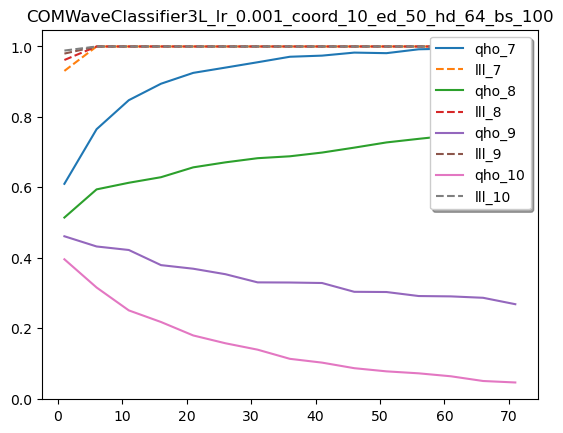

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for j in range(4):
    ax.plot([1 + 5*i for i in range(15)],qho_acc[j,:])
    ax.plot([1 + 5*i for i in range(15)],lll_acc[j,:], linestyle= 'dashed')

plt.title(model_string)
ax.legend(sum([[f"qho_{i}",f"lll_{i}"] for i in range(7,11)],[]), loc='upper right', shadow=True)

In [22]:
model_string

'2COMWaveClassifier3L_lr_0.01_coord_10_ed_50_hd_64_bs_100'